# Out degree comparison analysis
Compare nodes' out degrees with the highest out degreee in the giant componenent network to analyse the gradual spike. Hoping to get nodes that may be causing the gradual increase in the system 

In [1]:
import os
from raphtory import Graph

# Specify the file path
binecode_path = "C:/ms_bincode/Graph_5"

# Load the file
if os.path.isfile(binecode_path):
    g5 = Graph.load_from_file(binecode_path)
    print(g5)


binecode_path = "C:/ms_bincode/Graph_10"

# Load the file
if os.path.isfile(binecode_path):
    g10 = Graph.load_from_file(binecode_path)
    print(g10)


Graph(number_of_edges=91131, number_of_vertices=25648, number_of_temporal_edges=144899593, earliest_time="14400000", latest_time="17999999")
Graph(number_of_edges=156496, number_of_vertices=35921, number_of_temporal_edges=253533994, earliest_time="32400000", latest_time="35999999")


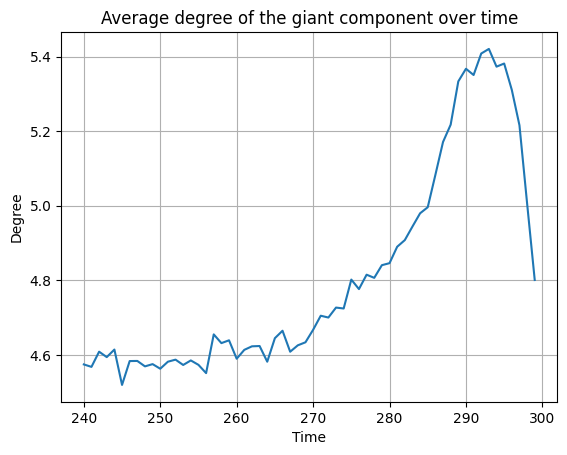

In [2]:
from collections import Counter
from raphtory import algorithms as rp
import matplotlib.pyplot as plt
import pandas as pd

# Run a community detection algorithm which checks lcc in the graph
lcc =  rp.weakly_connected_components(g5)

# Make it a dictionary
components_dict = lcc.get_all()

# Count the frequency of each component ID
component_sizes = Counter(components_dict.values())

# Find the top ten giant component
gc = component_sizes.most_common(1)

# Create a list to hold names of the nodes in the gc
gc_nodes = []

# Populate the list
for name, component_id in components_dict.items():
    if component_id == gc[0][0]:
        gc_nodes.append(name)

# Make a subgraph
gc5_subgraph = g5.subgraph(gc_nodes)
gc5_subgraph

"""
Diagram which gives the average degree of the giant component over time
"""

num_temp_edges = []
time = []

for windowed_graph in gc5_subgraph.rolling(window=60000):
    result = rp.average_degree(windowed_graph)
    num_temp_edges.append(result)
    time_in_minutes = windowed_graph.earliest_time / 60000
    time.append(time_in_minutes)

plt.plot(time, num_temp_edges)
plt.xlabel("Time")
plt.ylabel("Degree")
plt.title("Average degree of the giant component over time")
plt.grid(True)

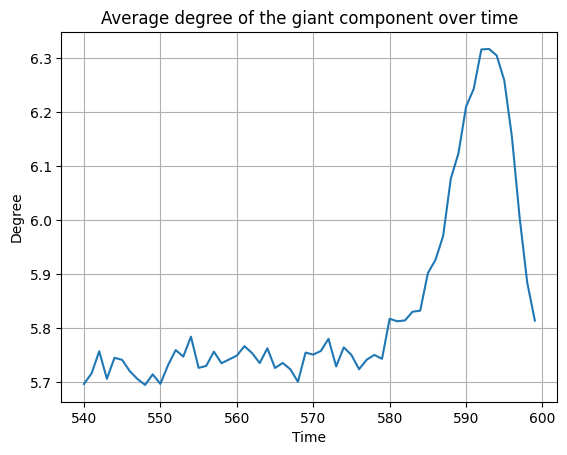

In [3]:
from collections import Counter
from raphtory import algorithms as rp
import matplotlib.pyplot as plt
import pandas as pd

# Run a community detection algorithm which checks lcc in the graph
lcc =  rp.weakly_connected_components(g10)

# Make it a dictionary
components_dict = lcc.get_all()

# Count the frequency of each component ID
component_sizes = Counter(components_dict.values())

# Find the top ten giant component
gc = component_sizes.most_common(1)

# Create a list to hold names of the nodes in the gc
gc_nodes = []

# Populate the list
for name, component_id in components_dict.items():
    if component_id == gc[0][0]:
        gc_nodes.append(name)

# Make a subgraph
gc10_subgraph = g10.subgraph(gc_nodes)
gc10_subgraph

"""
Diagram which gives the average degree of the giant component over time
"""

num_temp_edges = []
time = []

for windowed_graph in gc10_subgraph.rolling(window=60000):
    result = rp.average_degree(windowed_graph)
    num_temp_edges.append(result)
    time_in_minutes = windowed_graph.earliest_time / 60000
    time.append(time_in_minutes)

plt.plot(time, num_temp_edges)
plt.xlabel("Time")
plt.ylabel("Degree")
plt.title("Average degree of the giant component over time")
plt.grid(True)

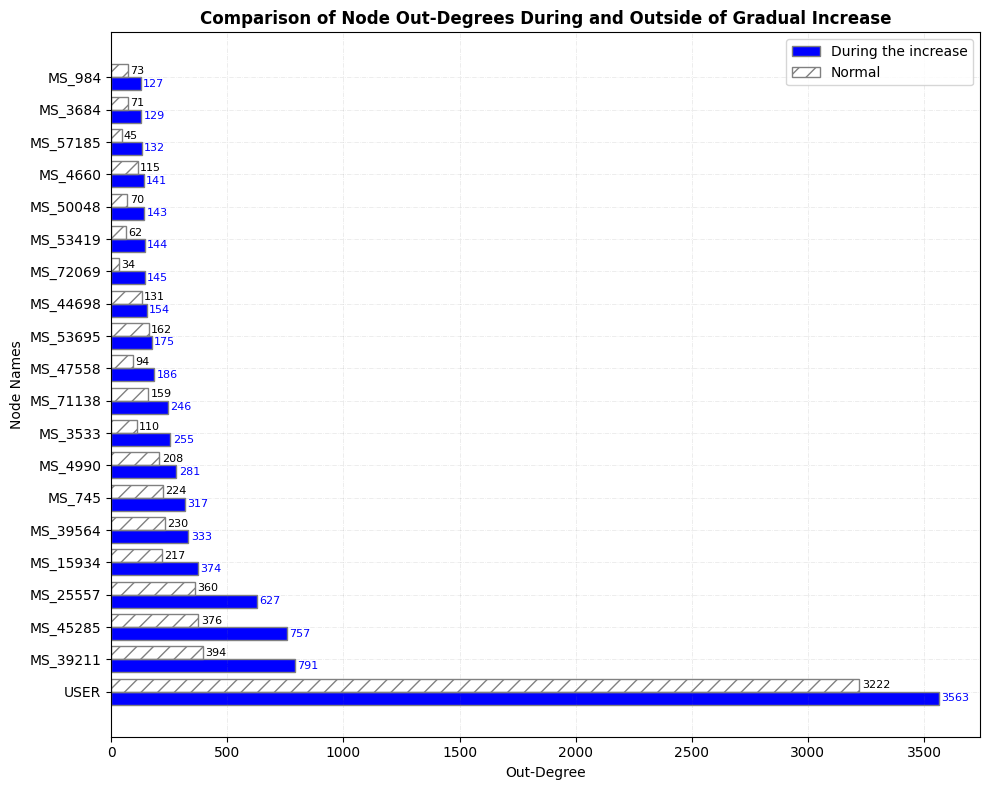

In [4]:
import numpy as np

# 1. Retrieve all nodes and their out-degrees
nodes_out_degrees_g10 = [(node.name, node.out_degree()) for node in gc10_subgraph.vertices]

# 2. Sort nodes by their out-degree in descending order
sorted_nodes = sorted(nodes_out_degrees_g10, key=lambda x: x[1], reverse=True)

# 3. Select the top 20 nodes
top_10_nodes = sorted_nodes[:20]

# Retrieve all nodes in the g10 subgraph as a dictionary for quick access
nodes_in_no_increase = {node.name: node for node in gc5_subgraph.vertices}

# Initialize a list to store the comparison results
comparison_results = []

# Iterate over the top 10 nodes identified in the first subgraph
for name, spike_out_degree in top_10_nodes:
    # Check if the node exists in the second subgraph
    if name in nodes_in_no_increase:
        # Retrieve the node's out-degree in the second subgraph
        new_out_degree = nodes_in_no_increase[name].out_degree()
        # Store the comparison
        comparison_results.append((name, spike_out_degree, new_out_degree))
    else:
        # If the node doesn't exist in the second subgraph, note it as not found
        comparison_results.append((name, spike_out_degree, "Not found in second subgraph"))

names = []
increase_out_degrees = []
normal_out_degrees = []

for name, spike_out_degree, new_out_degree in comparison_results:
    names.append(name)
    increase_out_degrees.append(spike_out_degree)
    normal_out_degrees.append(new_out_degree)

fig, ax = plt.subplots(figsize=(10, 8))
r = np.arange(len(names))
r1 = r
r2 = [x + 0.4 for x in r]

# Make the plot
ax.barh(r1, increase_out_degrees, color='blue', height=0.4, label='During the increase', edgecolor='grey')
ax.barh(r2, normal_out_degrees, color='none', height=0.4, label='Normal', edgecolor='grey', hatch='//')

# Add x,y gridlines
ax.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

# Add annotation to bars
for i in range(len(names)):
    # Positioning the text on the right end of the bar
    ax.text(increase_out_degrees[i] + 10, i, str(increase_out_degrees[i]), va='center', color='blue', fontsize=8)
    ax.text(normal_out_degrees[i] + 10, i + 0.4, str(normal_out_degrees[i]), va='center', color='black', fontsize=8)

# Add x, y axis labels
plt.xlabel('Out-Degree')
plt.ylabel('Node Names')

# Add legend
plt.legend()

# Add titles and labels
plt.yticks([r + 0.2 for r in range(len(names))], names)
plt.title('Comparison of Node Out-Degrees During and Outside of Gradual Increase', fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()